This notebook improves a pipeline's inference speed by using `float16`s and changing to a different `scheduler`.

In [1]:
from diffusers import DiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(model_id, use_safetensors=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [2]:
prompt = "photo of magic forest path, cold colors, muted, 8k"

In [3]:
pipeline = pipeline.to("cuda")

In [4]:
import torch

generator = torch.Generator("cuda").manual_seed(1)

  0%|          | 0/50 [00:00<?, ?it/s]

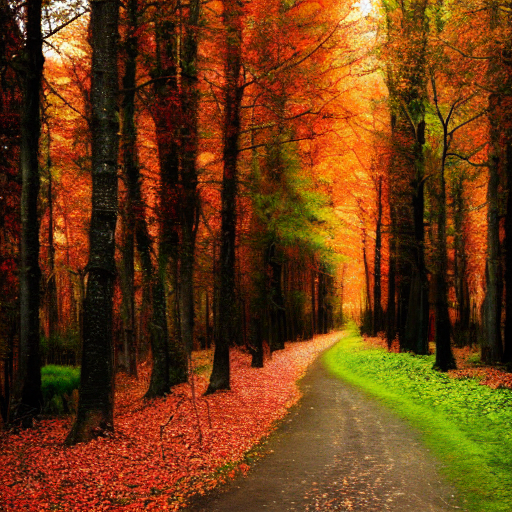

In [5]:
image = pipeline(prompt, generator=generator).images[0]
image

In [6]:
del pipeline
import gc
gc.collect()
torch.cuda.empty_cache()


We can use `float16`s instead of the default `float32`s to speed up inference.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

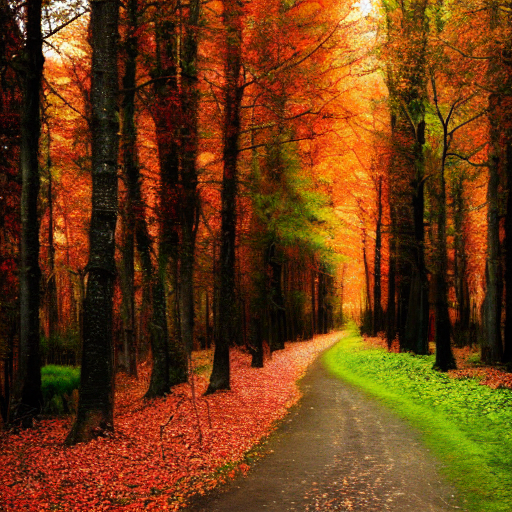

In [7]:
import torch

pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(1)
image = pipeline(prompt, generator=generator).images[0]
image

We can replace the scheduler with one that works well with fewer inference steps to speed things up further.

In [8]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.utils.dummy_torch_and_scipy_objects.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultist

In [9]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)


  0%|          | 0/20 [00:00<?, ?it/s]

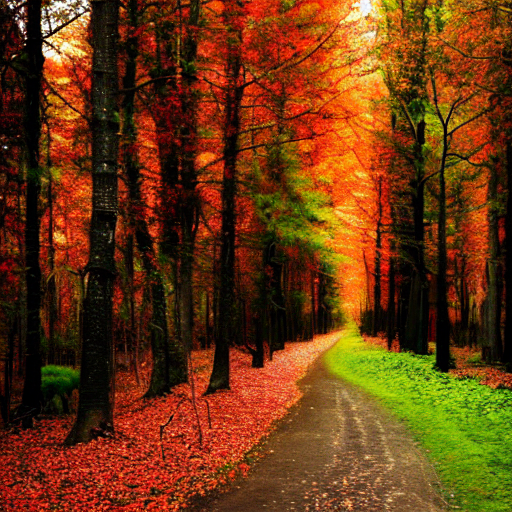

In [12]:
generator = torch.Generator("cuda").manual_seed(1)
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]
image

Different schedulers may give us slightly different image results.